<a href="https://colab.research.google.com/github/Natasha617/-advanced-machine-learning/blob/main/Log_Reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Применение логистической регрессии для решения задачи классификации

# Описание набора данных

Данный набор содержит информацию о пассажирах корабля «Титаник», затонувшего в ночь на 15-е апреля 1912 года. Некоторое количество пассажиров спаслось, чему способствовало множество различных факторов, включая их пол, возраст, на какой палубе находилась их кабина, социальный статус, и т.д.

Набор данных состоит из различных признаков, описывающих информацию о пассажирах. Каждая строка таблицы — отдельный пассажир, вся информация о нем содержится в его строке.

Описание датасета:
- **Survived** (целевой признак): выжил ли пассажир (0 = Нет, 1 = Да);
- **Pclass**: класс каюты (1 = 1st, 2 = 2nd, 3 = 3rd);
- **Sex**: пол (female или male)
- **Age**: возраст в годах
- **SibSp**: количество братьев, сестёр (в том числе сводных) и супругов на борту
- **Parch**: количество детей и родителей на борту
- **Ticket**: номер билета
- **Fare**: стоимость проезда пассажира
- **Cabin**: номер каюты
- **Embarked**: порт посадки пассажира (C = Cherbourg, Q = Queenstown, S = Southampton).

Необходимо решить задачу классификации и научиться предсказывать целовой признак **Survived** — выживет ли пассажир — по соответсвующим ему нецелевым признакам.


# Подготовка и первичный анализ данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from google.colab import drive
from sklearn.model_selection import train_test_split

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp "/content/drive/MyDrive/magamed/introduction ML/LogisticReg/titanic_train.csv" /content/data_titanic.csv

In [4]:
data = pd.read_csv('data_titanic.csv')
data

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,3,1,"Smyth, Miss. Julia",female,NaN,0,0,335432,7.7333,NaN,Q,NaN
1,3,1,"Glynn, Miss. Mary Agatha",female,NaN,0,0,335677,7.7500,NaN,Q,"Co Clare, Ireland Washington, DC"
2,3,1,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)",female,38.0,0,0,2688,7.2292,NaN,C,NaN
3,3,0,"Vovk, Mr. Janko",male,22.0,0,0,349252,7.8958,NaN,S,NaN
4,3,0,"de Pelsmaeker, Mr. Alfons",male,16.0,0,0,345778,9.5000,NaN,S,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
976,3,1,"Howard, Miss. May Elizabeth",female,NaN,0,0,A. 2. 39186,8.0500,NaN,S,NaN
977,3,1,"Dorking, Mr. Edward Arthur",male,19.0,0,0,A/5. 10482,8.0500,NaN,S,"England Oglesby, IL"
978,2,0,"Gillespie, Mr. William Henry",male,34.0,0,0,12233,13.0000,NaN,S,"Vancouver, BC"
979,3,0,"Barton, Mr. David John",male,22.0,0,0,324669,8.0500,NaN,S,"England New York, NY"


Установите количество пропущенных значений поля <code>age</code>:

In [5]:
data['age'].isna().sum()

199

Определите долю выживших

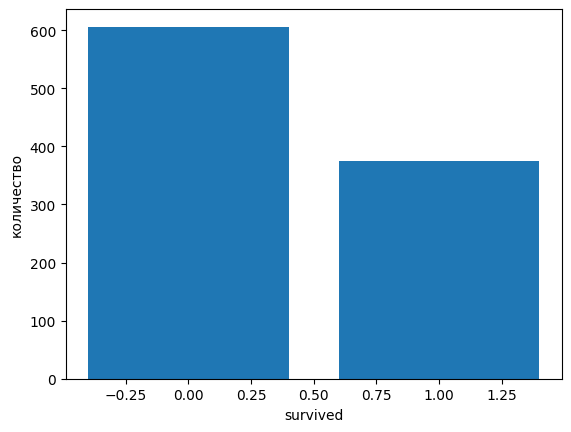

In [6]:
x_value = data['survived'].value_counts()
plt.bar(x_value.index,x_value.values)
plt.xlabel('survived')
plt.ylabel('количество')
plt.show()

In [7]:
data['survived'].value_counts()

0    606
1    375
Name: survived, dtype: int64

Определите долю пропущенных значений в рамках каждого признака и избавьтесь от тех признаков, где доля пропусков больше трети. Также удалите колонку <code>ticket</code>, вряд ли эта информация будет полезной.

In [8]:
data.isna().sum()

pclass         0
survived       0
name           0
sex            0
age          199
sibsp          0
parch          0
ticket         0
fare           0
cabin        769
embarked       0
home.dest    414
dtype: int64

Всего строк 981 --> в столбцах cabin и home.dest пропусков больше трети --> удаляем эти столбцы

In [9]:
data_drop = data.copy() #данные с удаленными колонками, в которых пропусков больше трети

In [10]:
data_drop = data_drop.drop(columns = ['cabin', 'home.dest', 'ticket'])

Из описания набора данных видно, что колонки <code>sibsp</code> и <code>parch</code> по сути отвечают за размер семьи. Замените эти две колонки на колонку <code>fam_size</code>, значения которой будут вычисляться как сумма соответствующих значений в колонках <code>sibsp</code> и <code>parch</code>.

In [11]:
data_drop['fam_size'] = data_drop['sibsp']+data['parch']
data_drop = data_drop.drop(columns = ['sibsp', 'parch'])

In [12]:
data_drop['fam_size'].mean()

0.8664627930682977

Полученный датасет будем называть **исходным** (выброшенные на этом этапе признаки не нужно возвращать ни на одном из последующих этапов выполнения задания). Вычислите полученное число предикторов.

In [13]:
data_drop

,pclass,survived,name,sex,age,fare,embarked,fam_size
0,3,1,"Smyth, Miss. Julia",female,NaN,7.7333,Q,0
1,3,1,"Glynn, Miss. Mary Agatha",female,NaN,7.7500,Q,0
2,3,1,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)",female,38.0,7.2292,C,0
3,3,0,"Vovk, Mr. Janko",male,22.0,7.8958,S,0
4,3,0,"de Pelsmaeker, Mr. Alfons",male,16.0,9.5000,S,0
...,...,...,...,...,...,...,...,...
976,3,1,"Howard, Miss. May Elizabeth",female,NaN,8.0500,S,0
977,3,1,"Dorking, Mr. Edward Arthur",male,19.0,8.0500,S,0
978,2,0,"Gillespie, Mr. William Henry",male,34.0,13.0000,S,0
979,3,0,"Barton, Mr. David John",male,22.0,8.0500,S,0


На основе имеющейся статистики оцените вероятность выжить если пассажир -- представитель определенной категории (указана в вашем индивидуальном задании)

In [14]:
data_drop[(data_drop['sex']=='male') & (data_drop['pclass']==3)]['survived'].value_counts()

0    310
1     61
Name: survived, dtype: int64

Постройте гистограммы выжиших и невыживших по возрастам.

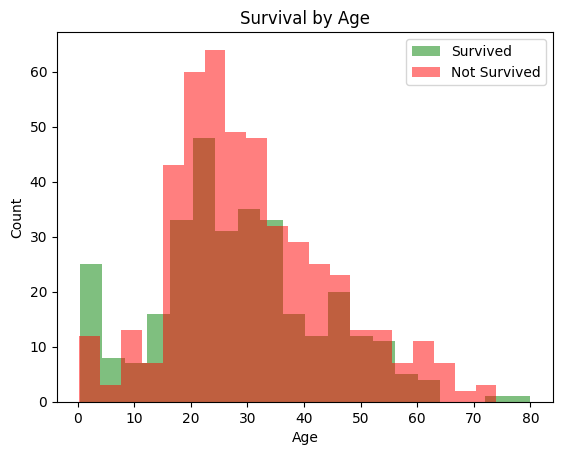

In [15]:
import matplotlib.pyplot as plt

# Выбор данных о выживших и их возрасте
survived = data_drop[data_drop['survived'] == 1]['age'].dropna()
# Выбор данных о невыживших и их возрасте
not_survived = data_drop[data_drop['survived'] == 0]['age'].dropna()

# Построение гистограммы выживших по возрастам
plt.hist(survived, bins=20, alpha=0.5, label='Survived', color='green')
# Построение гистограммы невыживших по возрастам
plt.hist(not_survived, bins=20, alpha=0.5, label='Not Survived', color='red')

# Добавление названий осей и заголовка
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Survival by Age')

# Добавление легенды
plt.legend()

# Отображение гистограммы
plt.show()

In [16]:
# так как сказали, что колонки, которые я до этого удаляла не понадобятся, то сохраню эти данные как data(исходные)
data = data_drop.copy()

# Модель на основе числовых признаков

## Удаление строк с пропусками

В качестве базовой модели имеет смысл построить модель с минимальными трудозатратами.

Из исходного датасета удалите все категориальные признаки, а также строки, содержащие пропуски.

При помощи <code>train_test_split()</code> разбейте набор данных на обучающую и тестовую выборки<b> с параметрами, указанными в вашем задании</b>. Используйте стратификацию по колонке <code>survived</code>.

Обучите модель <code>LogisticRegression()</code> <b>с параметрами, указанными в вашем задании</b>, на тренировочных данных, оцените на тестовых.

Вычислите <code>f1_score</code> модели на тестовых данных (рекомендуем использовать <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html">соответствующую функцию</a> с параметрами по умолчанию.



In [17]:
data

,pclass,survived,name,sex,age,fare,embarked,fam_size
0,3,1,"Smyth, Miss. Julia",female,NaN,7.7333,Q,0
1,3,1,"Glynn, Miss. Mary Agatha",female,NaN,7.7500,Q,0
2,3,1,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)",female,38.0,7.2292,C,0
3,3,0,"Vovk, Mr. Janko",male,22.0,7.8958,S,0
4,3,0,"de Pelsmaeker, Mr. Alfons",male,16.0,9.5000,S,0
...,...,...,...,...,...,...,...,...
976,3,1,"Howard, Miss. May Elizabeth",female,NaN,8.0500,S,0
977,3,1,"Dorking, Mr. Edward Arthur",male,19.0,8.0500,S,0
978,2,0,"Gillespie, Mr. William Henry",male,34.0,13.0000,S,0
979,3,0,"Barton, Mr. David John",male,22.0,8.0500,S,0


In [18]:
data_drop = data.drop(columns = ['name', 'sex', 'embarked']) # вот теперь тут будут лежать данные без категориальных значений
data_drop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981 entries, 0 to 980
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    981 non-null    int64  
 1   survived  981 non-null    int64  
 2   age       782 non-null    float64
 3   fare      981 non-null    float64
 4   fam_size  981 non-null    int64  
dtypes: float64(2), int64(3)
memory usage: 38.4 KB


In [19]:
data_drop[data_drop['age'].isna()!=True]

,pclass,survived,age,fare,fam_size
2,3,1,38.0,7.2292,0
3,3,0,22.0,7.8958,0
4,3,0,16.0,9.5000,0
5,3,1,29.0,7.7500,0
7,1,0,25.0,26.0000,0
...,...,...,...,...,...
975,2,0,19.0,10.5000,0
977,3,1,19.0,8.0500,0
978,2,0,34.0,13.0000,0
979,3,0,22.0,8.0500,0


In [20]:
x_train,x_test,y_train,y_test = train_test_split(data_drop[data_drop['age'].isna()!=True].drop(columns = 'survived'),
                                                 data_drop[data_drop['age'].isna()!=True]['survived'], test_size=0.2,
                                                 random_state=21,
                                                 stratify=data_drop[data_drop['age'].isna()!=True]['survived'])

In [21]:
log1 = LogisticRegression(random_state=21, max_iter=1000).fit(x_train,y_train)
f1_score(y_test, log1.predict(x_test))

0.5660377358490566

## Заполнение пропусков средним

Качество полученной модели оставляет желать лучшего. Имеет смысл попробовать заполнить пропуски. Из исходного набора данных удалите категориальные признаки, а пропуски заполните средним по столбцу. Далее аналогично: разделение, обучение, оценка.

Вычислите <code>f1_score</code> модели на тестовых данных

In [22]:
name_col = data_drop.columns

In [23]:
data_drop

,pclass,survived,age,fare,fam_size
0,3,1,NaN,7.7333,0
1,3,1,NaN,7.7500,0
2,3,1,38.0,7.2292,0
3,3,0,22.0,7.8958,0
4,3,0,16.0,9.5000,0
...,...,...,...,...,...
976,3,1,NaN,8.0500,0
977,3,1,19.0,8.0500,0
978,2,0,34.0,13.0000,0
979,3,0,22.0,8.0500,0


In [24]:
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer( strategy='mean').fit(data_drop)
data_drop = pd.DataFrame(imp_mean.transform(data_drop))
data_drop.columns = name_col

In [25]:
data_drop

,pclass,survived,age,fare,fam_size
0,3.0,1.0,29.963448,7.7333,0.0
1,3.0,1.0,29.963448,7.7500,0.0
2,3.0,1.0,38.000000,7.2292,0.0
3,3.0,0.0,22.000000,7.8958,0.0
4,3.0,0.0,16.000000,9.5000,0.0
...,...,...,...,...,...
976,3.0,1.0,29.963448,8.0500,0.0
977,3.0,1.0,19.000000,8.0500,0.0
978,2.0,0.0,34.000000,13.0000,0.0
979,3.0,0.0,22.000000,8.0500,0.0


In [26]:
x_train,x_test,y_train,y_test = train_test_split(data_drop.drop(columns = 'survived'),
                                                 data_drop['survived'], test_size=0.2,
                                                 random_state=21,
                                                 stratify=data_drop['survived'])

In [27]:
log1 = LogisticRegression(random_state=21, max_iter=1000).fit(x_train,y_train)
f1_score(y_test, log1.predict(x_test))

0.4761904761904762

## Заполнение пропусков на основе обращения


Очевидно, что заполнение пропусков в колонке <code>age</code> средним — не самая разумная идея. Возможно, стоит выполнить эту процедуру как-то более интеллектуально, например, с оглядкой на обращение к человеку.

Можно заметить, что исходный датасет в столбце <code>name</code> содержит информацию о социальном статусе пассажира, а именно присутсвуют обращения <code>Mr., Mrs., Dr.</code> и т.д. На основе этой информации можно попробовать сделать предположение о возрасте пассажира.

Верните в рассмотрение колонку <code>name</code>. Создайте отдельную колонку <code>honorific</code> и поместите туда значения обращений.

Вычислите число уникальных обращений.

In [28]:
data_drop['name'] = data['name']
data_drop['age'] = data['age']
data_drop

,pclass,survived,age,fare,fam_size,name
0,3.0,1.0,NaN,7.7333,0.0,"Smyth, Miss. Julia"
1,3.0,1.0,NaN,7.7500,0.0,"Glynn, Miss. Mary Agatha"
2,3.0,1.0,38.0,7.2292,0.0,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)"
3,3.0,0.0,22.0,7.8958,0.0,"Vovk, Mr. Janko"
4,3.0,0.0,16.0,9.5000,0.0,"de Pelsmaeker, Mr. Alfons"
...,...,...,...,...,...,...
976,3.0,1.0,NaN,8.0500,0.0,"Howard, Miss. May Elizabeth"
977,3.0,1.0,19.0,8.0500,0.0,"Dorking, Mr. Edward Arthur"
978,2.0,0.0,34.0,13.0000,0.0,"Gillespie, Mr. William Henry"
979,3.0,0.0,22.0,8.0500,0.0,"Barton, Mr. David John"


In [29]:
def honorific(x):
  x = x.split(', ')
  x = x[1]
  x = x.split('.')
  x= x[0]
  return x

In [30]:
data_drop['honorific'] = data_drop['name'].apply(honorific)
data_drop['honorific'].value_counts()

Mr              572
Miss            194
Mrs             145
Master           46
Rev               6
Dr                6
Col               3
Mlle              2
Ms                2
Dona              1
the Countess      1
Major             1
Don               1
Capt              1
Name: honorific, dtype: int64

In [31]:
len(data_drop['honorific'].value_counts())

14

Скорее всего имеет смысл сократить число обращений, добавив малочисленные группы к более многочисленным, так как принципиальной разницы между, например, <code>Don</code> и <code>Mr</code>, видимо, нет. Отметим, что <code>Master</code> — это прежнее обращение к ребенку, с этим обращением будем работать отдельно.




Выполните следующие замены:

<code>Mr</code> $\leftarrow$ <code>['Rev', 'Col', 'Dr', 'Major', 'Don', 'Capt']</code>

<code>Mrs</code> $\leftarrow$ <code> ['Dona', 'Countess']</code>

<code>Miss</code> $\leftarrow$ <code> ['Mlle', 'Ms']</code>

In [32]:
def d(x):
  if x in ['Rev', 'Col', 'Dr', 'Major', 'Don', 'Capt']:
    return 'Mr'
  elif x in ['Dona', 'the Countess']:
    return 'Mrs'
  elif x in ['Mlle', 'Ms']:
    return 'Miss'
  else:
    return x

In [33]:
data_drop['honorific'] = data_drop['honorific'].apply(d)

Вычислите долю строк со значением <code>Master</code> относительно числа всех мужчин

In [34]:
data['sex'].value_counts()

male      636
female    345
Name: sex, dtype: int64

In [35]:
data_drop['honorific'].value_counts()

Mr        590
Miss      198
Mrs       147
Master     46
Name: honorific, dtype: int64

In [36]:
46/636

0.07232704402515723

Вычислите средний возраст категории Mr

In [37]:
round(data_drop[data_drop['honorific']=='Mr']['age'].mean(),3)

32.9

Заполните пропуски в колонке <code>age</code> средним, соответствующим среднему категории <code>honorific</code>.

Избавьтесь от нечисловых признаков. Далее аналогично: разделение, обучение, оценка.

Вычислите <code>f1_score</code> модели на тестовых данных

In [38]:
age_mean_dict = {'Mr': data_drop[data_drop['honorific']=='Mr']['age'].mean(),
                 'Miss': data_drop[data_drop['honorific']=='Miss']['age'].mean(),
                 'Mrs': data_drop[data_drop['honorific']=='Mrs']['age'].mean(),
                 'Master': data_drop[data_drop['honorific']=='Master']['age'].mean(),
                 }

In [39]:

def mean_age(x):
  if x == 'Mr':
    return age_mean_dict['Mr']
  elif x == 'Miss':
    return age_mean_dict['Miss']
  elif x == 'Mrs':
    return age_mean_dict['Mrs']
  elif x == 'Master':
    return age_mean_dict['Master']

In [40]:
for i in range(len(data_drop)):
  if np.isnan(data_drop.loc[i,'age']):
    data_drop.loc[i,'age'] = mean_age(data_drop.loc[i,'honorific'])

In [41]:
data_drop = data_drop.drop(columns = 'name')

In [42]:
x_train,x_test,y_train,y_test = train_test_split(data_drop.drop(columns = ['survived', 'honorific']),
                                                 data_drop['survived'], test_size=0.2,
                                                 random_state=21,
                                                 stratify=data_drop['survived'])

In [43]:
log3 = LogisticRegression(random_state=21, max_iter=1000).fit(x_train,y_train)
f1_score(y_test, log3.predict(x_test))

0.48818897637795283

In [44]:
data_drop

,pclass,survived,age,fare,fam_size,honorific
0,3.0,1.0,22.005765,7.7333,0.0,Miss
1,3.0,1.0,22.005765,7.7500,0.0,Miss
2,3.0,1.0,38.000000,7.2292,0.0,Mrs
3,3.0,0.0,22.000000,7.8958,0.0,Mr
4,3.0,0.0,16.000000,9.5000,0.0,Mr
...,...,...,...,...,...,...
976,3.0,1.0,22.005765,8.0500,0.0,Miss
977,3.0,1.0,19.000000,8.0500,0.0,Mr
978,2.0,0.0,34.000000,13.0000,0.0,Mr
979,3.0,0.0,22.000000,8.0500,0.0,Mr


In [45]:
data_drop['sex'],data_drop['embarked'] = data['sex'].values, data['embarked'].values

In [46]:
data_drop

,pclass,survived,age,fare,fam_size,honorific,sex,embarked
0,3.0,1.0,22.005765,7.7333,0.0,Miss,female,Q
1,3.0,1.0,22.005765,7.7500,0.0,Miss,female,Q
2,3.0,1.0,38.000000,7.2292,0.0,Mrs,female,C
3,3.0,0.0,22.000000,7.8958,0.0,Mr,male,S
4,3.0,0.0,16.000000,9.5000,0.0,Mr,male,S
...,...,...,...,...,...,...,...,...
976,3.0,1.0,22.005765,8.0500,0.0,Miss,female,S
977,3.0,1.0,19.000000,8.0500,0.0,Mr,male,S
978,2.0,0.0,34.000000,13.0000,0.0,Mr,male,S
979,3.0,0.0,22.000000,8.0500,0.0,Mr,male,S


# Модель с использование категориальных признаков

В исходном наборе данных заполните пропуски колонки <code>age</code> значениями на основе обращений (как в предыдущем пункте).

Не используйте признаки <code>name</code> и <code>honorific</code>. Они свою функцию выполнили.

Произведите <code>one-hot</code> кодировние нечисловых признаков, например, с помощью <code>pd.get_dummies(drop_first=True)</code>. Далее по знакомой схеме: разделение, обучение, оценка.

Вычислите <code>f1_score</code> модели на тестовых данных

In [47]:
data_drop = pd.get_dummies(data_drop, drop_first = True)
data_drop = data_drop.drop(columns = ['honorific_Miss',	'honorific_Mr',	'honorific_Mrs'	])


In [48]:
x_train,x_test,y_train,y_test = train_test_split(data_drop.drop(columns = ['survived']),
                                                 data_drop['survived'], test_size=0.2,
                                                 random_state=21,
                                                 stratify=data_drop['survived'])

In [67]:
log3 = LogisticRegression(random_state=21, max_iter=1000, penalty=None).fit(x_train,y_train)
f1_score(y_test, log3.predict(x_test))

0.7402597402597403

# Часть 2

Используя весь датасет из предыдущего задания как обучающий, выполните предсказания для следующего набора данных. Для успешного выполнения задания необходимо, чтобы ваш результат превысил пороговое значение, равное 0.74. В качестве метрики используется f1_score.

In [50]:
!cp "/content/drive/MyDrive/magamed/introduction ML/LogisticReg/titanic_reserved.csv" /content/data_test.csv

In [51]:
data_test = pd.read_csv('data_test.csv')
data_test = data_test.drop(columns = [ 'home.dest','ticket','cabin'])
data_test

,pclass,name,sex,age,sibsp,parch,fare,embarked
0,3,"Sage, Mr. Frederick",male,NaN,8,2,69.5500,S
1,1,"Snyder, Mr. John Pillsbury",male,24.0000,1,0,82.2667,S
2,2,"Ashby, Mr. John",male,57.0000,0,0,13.0000,S
3,3,"Rosblom, Mr. Viktor Richard",male,18.0000,1,1,20.2125,S
4,2,"Doling, Miss. Elsie",female,18.0000,0,1,23.0000,S
...,...,...,...,...,...,...,...,...
323,1,"Brewe, Dr. Arthur Jackson",male,NaN,0,0,39.6000,C
324,1,"Romaine, Mr. Charles Hallace (""Mr C Rolmane"")",male,45.0000,0,0,26.5500,S
325,1,"Meyer, Mrs. Edgar Joseph (Leila Saks)",female,NaN,1,0,82.1708,C
326,2,"Caldwell, Master. Alden Gates",male,0.8333,0,2,29.0000,S


In [52]:
data_test_copy = data_test.copy()

In [53]:
data_test['honorific'] = data_test['name'].apply(honorific)
data_test['honorific'].value_counts()

Mr          185
Miss         66
Mrs          52
Master       15
Rev           2
Dr            2
Sir           1
Major         1
Lady          1
Col           1
Mme           1
Jonkheer      1
Name: honorific, dtype: int64

In [54]:
data_test['honorific'] = data_test['honorific'].apply(d)

In [55]:
age_mean_test = {'Mr': data_test[data_test['honorific']=='Mr']['age'].mean(),
                 'Miss': data_test[data_test['honorific']=='Miss']['age'].mean(),
                 'Mrs': data_test[data_test['honorific']=='Mrs']['age'].mean(),
                 'Master': data_test[data_test['honorific']=='Master']['age'].mean(),
                 }

def mean_age_test(x):
  if x == 'Mr':
    return age_mean_test['Mr']
  elif x == 'Miss':
    return age_mean_test['Miss']
  elif x == 'Mrs':
    return age_mean_test['Mrs']
  elif x == 'Master':
    return age_mean_test['Master']

In [56]:
for i in range(len(data_test)):
  if np.isnan(data_test.loc[i,'age']):
    data_test.loc[i,'age'] = mean_age_test(data_test.loc[i,'honorific'])

In [57]:
data_test['fam_size'] = data_test['parch']+ data_test['sibsp']
data_test= data_test.drop(columns = ['parch', 'sibsp'])
data_test

,pclass,name,sex,age,fare,embarked,honorific,fam_size
0,3,"Sage, Mr. Frederick",male,32.387755,69.5500,S,Mr,10
1,1,"Snyder, Mr. John Pillsbury",male,24.000000,82.2667,S,Mr,1
2,2,"Ashby, Mr. John",male,57.000000,13.0000,S,Mr,0
3,3,"Rosblom, Mr. Viktor Richard",male,18.000000,20.2125,S,Mr,2
4,2,"Doling, Miss. Elsie",female,18.000000,23.0000,S,Miss,1
...,...,...,...,...,...,...,...,...
323,1,"Brewe, Dr. Arthur Jackson",male,32.387755,39.6000,C,Mr,0
324,1,"Romaine, Mr. Charles Hallace (""Mr C Rolmane"")",male,45.000000,26.5500,S,Mr,0
325,1,"Meyer, Mrs. Edgar Joseph (Leila Saks)",female,36.977778,82.1708,C,Mrs,1
326,2,"Caldwell, Master. Alden Gates",male,0.833300,29.0000,S,Master,2


In [58]:
data_test = data_test.drop(columns= ['name','honorific'])

In [59]:
data_test.head()

,pclass,sex,age,fare,embarked,fam_size
0,3,male,32.387755,69.5500,S,10
1,1,male,24.000000,82.2667,S,1
2,2,male,57.000000,13.0000,S,0
3,3,male,18.000000,20.2125,S,2
4,2,female,18.000000,23.0000,S,1


In [60]:
data_test = pd.get_dummies(data_test, drop_first = True)

In [61]:
data_drop

,pclass,survived,age,fare,fam_size,sex_male,embarked_Q,embarked_S
0,3.0,1.0,22.005765,7.7333,0.0,0,1,0
1,3.0,1.0,22.005765,7.7500,0.0,0,1,0
2,3.0,1.0,38.000000,7.2292,0.0,0,0,0
3,3.0,0.0,22.000000,7.8958,0.0,1,0,1
4,3.0,0.0,16.000000,9.5000,0.0,1,0,1
...,...,...,...,...,...,...,...,...
976,3.0,1.0,22.005765,8.0500,0.0,0,0,1
977,3.0,1.0,19.000000,8.0500,0.0,1,0,1
978,2.0,0.0,34.000000,13.0000,0.0,1,0,1
979,3.0,0.0,22.000000,8.0500,0.0,1,0,1


In [64]:
data_test

,pclass,age,fare,fam_size,sex_male,embarked_Q,embarked_S
0,3,32.387755,69.5500,10,1,0,1
1,1,24.000000,82.2667,1,1,0,1
2,2,57.000000,13.0000,0,1,0,1
3,3,18.000000,20.2125,2,1,0,1
4,2,18.000000,23.0000,1,0,0,1
...,...,...,...,...,...,...,...
323,1,32.387755,39.6000,0,1,0,0
324,1,45.000000,26.5500,0,1,0,1
325,1,36.977778,82.1708,1,0,0,0
326,2,0.833300,29.0000,2,1,0,1


In [65]:
data_drop['age'] = data_drop['age'].apply(lambda x: int(x))
data_test['age'] = data_test['age'].apply(lambda x: int(x))

In [68]:
log4 = LogisticRegression(random_state=21, max_iter=1500,penalty=None).fit(data_drop.drop(columns = 'survived'),data_drop['survived'])
log4.predict(data_test)

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0.,
       1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0.,
       0., 0., 1., 0., 0.